## Preparação do ambiente

## install das libs utilizadas

In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install ucimlrepo

In [18]:
# IMPORTAR PACOTES ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Funções do Scikit-learn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning

# Algoritmos Evolutivos da biblioteca scikit-opt
from sko.GA import GA
from sko.DE import DE

# Extreme Learning Machine (se for usar)
import hpelm 

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Definição das Funções Auxiliares (Indivíduo e Fitness)
Funções principais que definem uma solução e como avaliá-la. 

Funções genéricas e funcionarão para qualquer dataset.

In [29]:
# FUNÇÕES AUXILIARES ---


def criar_individuo_aleatorio(num_features):
    """Cria um dicionário representando um indivíduo/solução aleatória."""
    feature_mask = np.random.randint(0, 2, size=num_features)
    if np.sum(feature_mask) == 0:
        feature_mask[np.random.randint(0, num_features)] = 1
    
    num_camadas_ocultas = np.random.randint(1, 3)
    neuronios = np.random.randint(5, 51, size=num_camadas_ocultas)
    hidden_layer_sizes = tuple(neuronios)
    learning_rate = np.random.uniform(0.001, 0.1)

    return {
        "feature_mask": feature_mask,
        "hidden_layer_sizes": hidden_layer_sizes,
        "learning_rate": round(learning_rate, 4)
    }

# parâmetro 'classifier_type'
def calcular_fitness(individuo, X_data, y_data, classifier_type='backprop'):
    """Calcula o fitness de um indivíduo usando o classificador especificado."""
    try:
        feature_mask = individuo["feature_mask"]
        hidden_layer_sizes = individuo["hidden_layer_sizes"]
        num_selected_features = np.sum(feature_mask)
        
        if num_selected_features == 0:
            return 999

        X_subset = X_data[:, feature_mask == 1]
        
        # Lógica para escolher o classificador
        if classifier_type == 'backprop':
            classifier = MLPClassifier(
                hidden_layer_sizes=individuo["hidden_layer_sizes"],
                learning_rate_init=individuo["learning_rate"],
                max_iter=300,
                random_state=42
            )
            accuracy_scores = cross_val_score(classifier, X_subset, y_data, cv=5, scoring='accuracy')
            error_rate = 1 - np.mean(accuracy_scores)

        elif classifier_type == 'elm':
            X_train_elm, X_val_elm, y_train_elm, y_val_elm = train_test_split(X_subset, y_data, test_size=0.2, random_state=42)
            num_entradas = X_train_elm.shape[1] if X_train_elm.shape[0] > 0 else 0
            if num_entradas == 0: return 999 # Evita erro se o split for vazio
            num_saidas = len(np.unique(y_data))
            
            elm = hpelm.ELM(num_entradas, num_saidas, classification="c")
            elm.add_neurons(hidden_layer_sizes[0], "sigm")
            elm.train(X_train_elm, y_train_elm)
            error_rate = elm.error(X_val_elm, y_val_elm)
        
        else:
            raise ValueError("Tipo de classificador desconhecido.")

        # Cálculo do fitness final
        rho = 0.9
        feature_reduction_cost = num_selected_features / X_data.shape[1]
        fitness = rho * error_rate + (1 - rho) * feature_reduction_cost
        
        return fitness
    except Exception:
        return 999

print("Funções 'criar_individuo_aleatorio' e 'calcular_fitness' definidas.")

Funções 'criar_individuo_aleatorio' e 'calcular_fitness' definidas.


## Função Principal do Experimento
Função principal. Ela encapsula todo o processo de otimização (rodar GA e DE) e a avaliação final. Ela recebe os dados X e y e retorna os resultados.

In [30]:
# FUNÇÃO PRINCIPAL ---

def executar_experimento(X, y, dataset_name, classifier_type='backprop'):
    """
    Executa o pipeline completo, agora incluindo a exibição de todos os detalhes
    da configuração ótima e os gráficos de convergência.
    """
    print(f"--- Iniciando experimento para {dataset_name} com classificador {classifier_type.upper()} ---")
    
    num_features = X.shape[1]
    stratify_option = y if len(np.unique(y)) > 1 and np.all(np.bincount(y) > 1) else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=stratify_option)

    def fitness_wrapper(p):
        feature_mask = (p[0:num_features] > 0.5).astype(int)
        num_neurons = int(p[num_features])
        learning_rate = p[num_features + 1]
        individuo = {"feature_mask": feature_mask, "hidden_layer_sizes": (num_neurons,), "learning_rate": learning_rate}
        return calcular_fitness(individuo, X_train, y_train, classifier_type=classifier_type)

    lb = [0] * num_features + [5, 0.001]
    ub = [1] * num_features + [50, 0.1]
    n_dim = num_features + 2

    # Execução do Algoritmo Genético (GA) ---
    print(f"Executando GA com {classifier_type.upper()}...")
    ga = GA(func=fitness_wrapper, n_dim=n_dim, size_pop=30, max_iter=50, prob_mut=0.01, lb=lb, ub=ub)
    best_x_ga, best_y_ga = ga.run()
    
    # >>>>> PLOTANDO GRÁFICO DE CONVERGENIA DO GA <<<<<
    # Plotar gráfico de convergência do GA
    plt.figure(figsize=(10, 5))
    plt.plot(ga.generation_best_Y)
    plt.title(f'Convergência do GA - {dataset_name} ({classifier_type.upper()})')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.show()
   

    # --- Execução da Evolução Diferencial (DE) ---
    print(f"Executando DE com {classifier_type.upper()}...")
    de = DE(func=fitness_wrapper, n_dim=n_dim, size_pop=30, max_iter=50, lb=lb, ub=ub)
    best_x_de, best_y_de = de.run()
    
    # >>>>> PLOTANDO GRÁFICO DE CONVERGENCIA DO DE <<<<<
    # Plotar gráfico de convergência do DE
    plt.figure(figsize=(10, 5))
    plt.plot(de.generation_best_Y)
    plt.title(f'Convergência do DE - {dataset_name} ({classifier_type.upper()})')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.show()
    

    # --- Análise e Relatório Final do Experimento ---
    resultados_fitness = {"GA": best_y_ga[0], "DE": best_y_de[0]}
    campeao_nome = min(resultados_fitness, key=resultados_fitness.get)
    campeao_vetor = best_x_ga if campeao_nome == "GA" else best_x_de
    
    best_mask_final = (campeao_vetor[0:num_features] > 0.5).astype(int)
    best_num_neurons_final = int(campeao_vetor[num_features])
    best_lr_final = campeao_vetor[num_features + 1]
    
    print("\n" + "="*50)
    print(f"🏆 ANÁLISE DO CAMPEÃO PARA: {dataset_name} com {classifier_type.upper()}")
    print("="*50)
    print(f"  - Algoritmo Vencedor: {campeao_nome} (Fitness: {resultados_fitness[campeao_nome]:.4f})")
    print("\n  --- Configuração Ótima de Hiperparâmetros ---")
    print(f"  - Número de Camadas Intermediárias: 1 (simplificado)")
    print(f"  - Número de Neurônios: ({best_num_neurons_final},)")
    print(f"  - Taxa de Aprendizado: {best_lr_final:.4f}")
    print(f"  - Número de Features Selecionadas: {np.sum(best_mask_final)} de {num_features}")
    
    X_train_final = X_train[:, best_mask_final == 1]
    X_test_final = X_test[:, best_mask_final == 1]

    report = "N/A"
    if np.sum(best_mask_final) > 0:
        y_pred_final = None
        if classifier_type == 'backprop':
            final_model = MLPClassifier(hidden_layer_sizes=(best_num_neurons_final,), learning_rate_init=best_lr_final, max_iter=1000, random_state=42)
            final_model.fit(X_train_final, y_train)
            y_pred_final = final_model.predict(X_test_final)
        elif classifier_type == 'elm':
            T_train_final = pd.get_dummies(y_train).values
            num_entradas = X_train_final.shape[1]
            num_saidas = T_train_final.shape[1]
            elm_final = hpelm.ELM(num_entradas, num_saidas, classification="c")
            elm_final.add_neurons(best_num_neurons_final, "sigm")
            elm_final.train(X_train_final, T_train_final)
            y_pred_one_hot = elm_final.predict(X_test_final)
            y_pred_final = np.argmax(y_pred_one_hot, axis=1)

        if y_pred_final is not None:
            report = classification_report(y_test, y_pred_final, zero_division=0)

    print("\n  --- Relatório Final de Eficácia no Conjunto de Teste ---")
    print(report)
    print("---------------------------------------------------\n")
    
    return {"configuracao": { "algoritmo": campeao_nome, "fitness": resultados_fitness[campeao_nome], "mascara_features": best_mask_final, "num_features": np.sum(best_mask_final), "arquitetura": (best_num_neurons_final,), "learning_rate": best_lr_final }, "relatorio_eficacia": report}

print("Função principal 'executar_experimento' definida com gráficos e detalhes.")


# # --- CÉLULA DA FUNÇÃO PRINCIPAL (VERSÃO FINAL E COMPLETA) ---

# def executar_experimento(X, y, dataset_name, classifier_type='backprop'):
#     """
#     Executa o pipeline completo, agora incluindo a exibição de todos os detalhes
#     da configuração ótima e os gráficos de convergência.
#     """
#     print(f"--- Iniciando experimento para {dataset_name} com classificador {classifier_type.upper()} ---")
    
#     num_features = X.shape[1]
#     stratify_option = y if len(np.unique(y)) > 1 and np.all(np.bincount(y) > 1) else None
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=stratify_option)

#     def fitness_wrapper(p):
#         feature_mask = (p[0:num_features] > 0.5).astype(int)
#         num_neurons = int(p[num_features])
#         learning_rate = p[num_features + 1]
#         individuo = {"feature_mask": feature_mask, "hidden_layer_sizes": (num_neurons,), "learning_rate": learning_rate}
#         return calcular_fitness(individuo, X_train, y_train, classifier_type=classifier_type)

#     lb = [0] * num_features + [5, 0.001]
#     ub = [1] * num_features + [50, 0.1]
#     n_dim = num_features + 2

#     # --- Execução do Algoritmo Genético (GA) ---
#     print(f"Executando GA com {classifier_type.upper()}...")
#     ga = GA(func=fitness_wrapper, n_dim=n_dim, size_pop=30, max_iter=50, prob_mut=0.01, lb=lb, ub=ub)
#     best_x_ga, best_y_ga = ga.run()
    
#     # NOVO: Plotar gráfico de convergência do GA
#     plt.figure(figsize=(10, 5))
#     plt.plot(ga.generation_best_Y)
#     plt.title(f'Convergência do GA - {dataset_name} ({classifier_type.upper()})')
#     plt.xlabel('Geração')
#     plt.ylabel('Melhor Fitness')
#     plt.grid(True)
#     plt.show()

#     # --- Execução da Evolução Diferencial (DE) ---
#     print(f"Executando DE com {classifier_type.upper()}...")
#     de = DE(func=fitness_wrapper, n_dim=n_dim, size_pop=30, max_iter=50, lb=lb, ub=ub)
#     best_x_de, best_y_de = de.run()
    
#     # NOVO: Plotar gráfico de convergência do DE
#     plt.figure(figsize=(10, 5))
#     plt.plot(de.generation_best_Y)
#     plt.title(f'Convergência do DE - {dataset_name} ({classifier_type.upper()})')
#     plt.xlabel('Geração')
#     plt.ylabel('Melhor Fitness')
#     plt.grid(True)
#     plt.show()

#     # --- Análise e Relatório Final do Experimento ---
#     resultados_fitness = {"GA": best_y_ga[0], "DE": best_y_de[0]}
#     campeao_nome = min(resultados_fitness, key=resultados_fitness.get)
#     campeao_vetor = best_x_ga if campeao_nome == "GA" else best_x_de
    
#     best_mask_final = (campeao_vetor[0:num_features] > 0.5).astype(int)
#     best_num_neurons_final = int(campeao_vetor[num_features])
#     best_lr_final = campeao_vetor[num_features + 1]
    
#     # NOVO: Exibição detalhada da configuração ótima
#     print("\n" + "="*50)
#     print(f"🏆 ANÁLISE DO CAMPEÃO PARA: {dataset_name} com {classifier_type.upper()}")
#     print("="*50)
#     print(f"  - Algoritmo Vencedor: {campeao_nome} (Fitness: {resultados_fitness[campeao_nome]:.4f})")
#     print("\n  --- Configuração Ótima de Hiperparâmetros ---")
#     print(f"  - Número de Camadas Intermediárias: 1")
#     print(f"  - Número de Neurônios por Camada: ({best_num_neurons_final},)")
#     print(f"  - Taxa de Aprendizado: {best_lr_final:.4f}")
#     print(f"  - Número de Features Selecionadas: {np.sum(best_mask_final)} de {num_features}")
#     print(f"  - Máscara de Features: {best_mask_final}")
    
#     X_train_final = X_train[:, best_mask_final == 1]
#     X_test_final = X_test[:, best_mask_final == 1]

#     y_pred_final = None
#     if classifier_type == 'backprop':
#         final_model = MLPClassifier(hidden_layer_sizes=(best_num_neurons_final,), learning_rate_init=best_lr_final, max_iter=1000, random_state=42)
#         if X_train_final.shape[1] > 0:
#             final_model.fit(X_train_final, y_train)
#             y_pred_final = final_model.predict(X_test_final)
#     elif classifier_type == 'elm':
#         T_train_final = pd.get_dummies(y_train).values
#         num_entradas = X_train_final.shape[1] if X_train_final.shape[1] > 0 else 1
#         num_saidas = T_train_final.shape[1]
#         elm_final = hpelm.ELM(num_entradas, num_saidas, classification="c")
#         elm_final.add_neurons(best_num_neurons_final, "sigm")
#         if X_train_final.shape[1] > 0:
#             elm_final.train(X_train_final, T_train_final)
#             y_pred_one_hot = elm_final.predict(X_test_final)
#             y_pred_final = np.argmax(y_pred_one_hot, axis=1)

#     print("\n  --- Relatório Final de Eficácia no Conjunto de Teste ---")
#     if y_pred_final is not None:
#         report = classification_report(y_test, y_pred_final, zero_division=0)
#         print(report)
#     else:
#         print("Nenhuma feature selecionada, o modelo não foi treinado.")
    
#     print("---------------------------------------------------\n")
    
#     # Armazena tudo em um dicionário para referência futura
#     return {
#         "configuracao": {
#             "algoritmo": campeao_nome,
#             "fitness": resultados_fitness[campeao_nome],
#             "mascara_features": best_mask_final,
#             "num_features": np.sum(best_mask_final),
#             "arquitetura": (best_num_neurons_final,),
#             "learning_rate": best_lr_final
#         },
#         "relatorio_eficacia": report if y_pred_final is not None else "N/A"
#     }

# print("Função principal 'executar_experimento' ATUALIZADA com gráficos e detalhes.")

Função principal 'executar_experimento' definida com gráficos e detalhes.


## Execução do Dataset Wine e Hepatitis
Carregar e Executar para o Dataset Wine
Carrega o dataset wine e chama a função principal para fazer todo o trabalho.

>>> INICIANDO TODOS OS EXPERIMENTOS DA TAREFA <<<

[INFO] Dataset Wine carregado.
[INFO] Dataset Hepatitis carregado e pré-processado.

>>> EXECUTANDO PARA DATASET: WINE <<<
--- Iniciando experimento para Wine com classificador BACKPROP ---
Executando GA com BACKPROP...


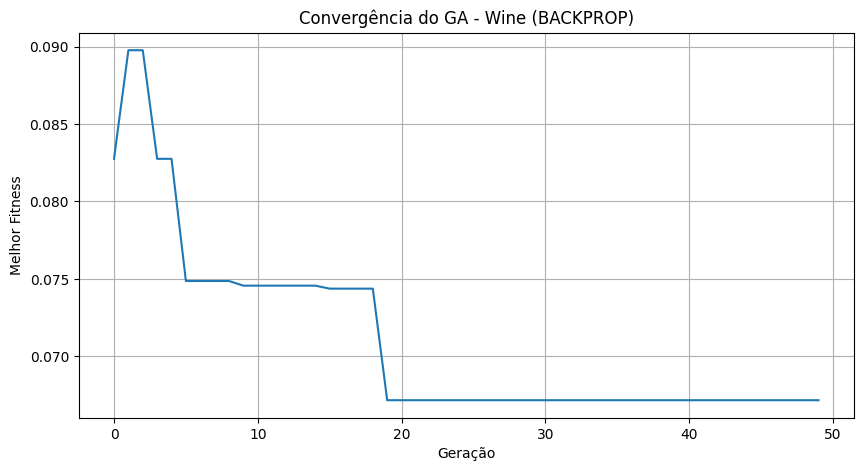

Executando DE com BACKPROP...


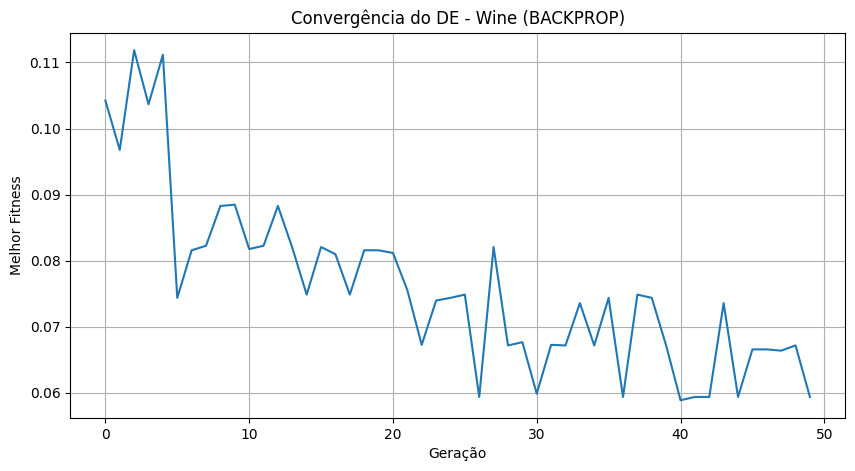


🏆 ANÁLISE DO CAMPEÃO PARA: Wine com BACKPROP
  - Algoritmo Vencedor: DE (Fitness: 0.0589)

  --- Configuração Ótima de Hiperparâmetros ---
  - Número de Camadas Intermediárias: 1 (simplificado)
  - Número de Neurônios: (32,)
  - Taxa de Aprendizado: 0.0299
  - Número de Features Selecionadas: 2 de 13

  --- Relatório Final de Eficácia no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.84      0.76      0.80        21
           2       0.88      1.00      0.94        15

    accuracy                           0.85        54
   macro avg       0.85      0.87      0.86        54
weighted avg       0.85      0.85      0.85        54

---------------------------------------------------

--- Iniciando experimento para Wine com classificador ELM ---
Executando GA com ELM...


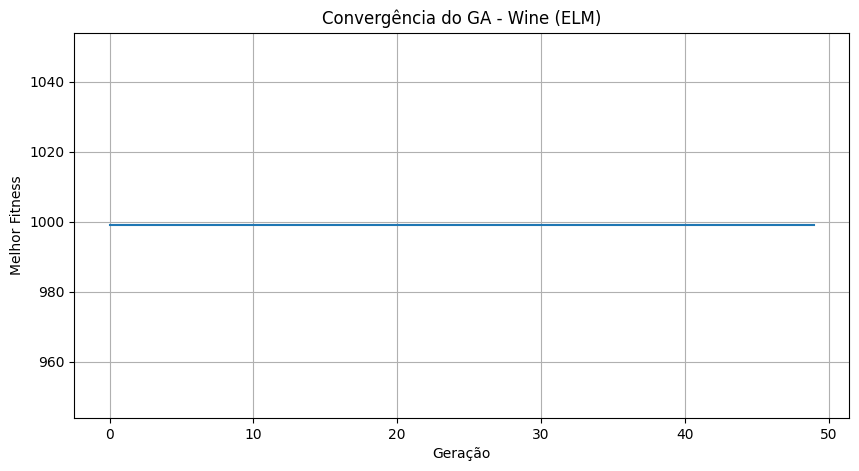

Executando DE com ELM...


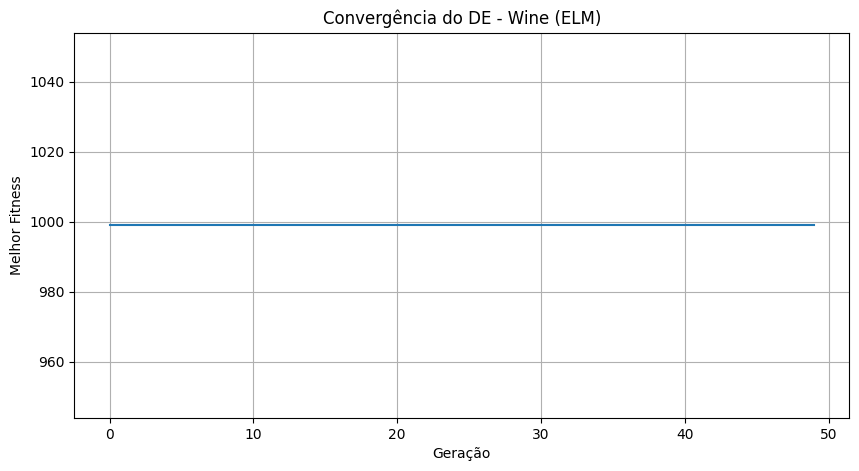


🏆 ANÁLISE DO CAMPEÃO PARA: Wine com ELM
  - Algoritmo Vencedor: GA (Fitness: 999.0000)

  --- Configuração Ótima de Hiperparâmetros ---
  - Número de Camadas Intermediárias: 1 (simplificado)
  - Número de Neurônios: (30,)
  - Taxa de Aprendizado: 0.0554
  - Número de Features Selecionadas: 6 de 13
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons

  --- Relatório Final de Eficácia no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.64      0.39      0.48        18
           1       0.56      0.86      0.68        21
           2       0.82      0.60      0.69        15

    accuracy                           0.63        54
   macro avg       0.67      0.62      0.62        54
weighted avg       0.66      0.63      0.62        54

---------------------------------------------------


>>> EXECUTANDO PARA DATASET: HEPATITIS <<<
--- Iniciando experimento para Hepatitis

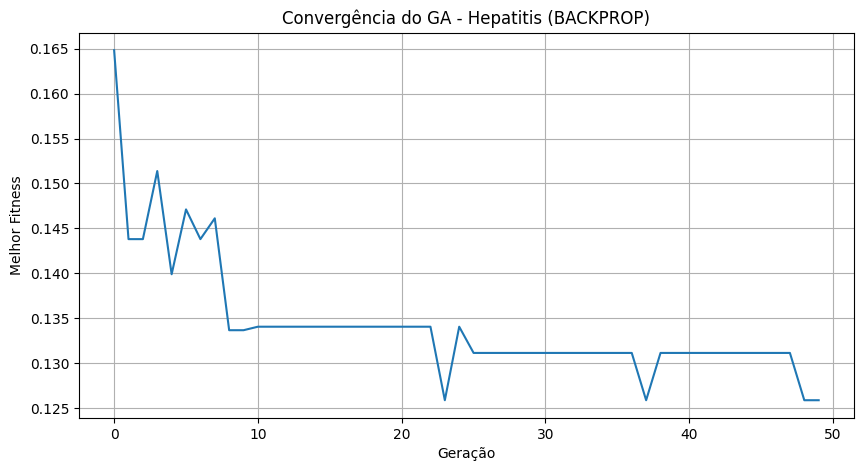

Executando DE com BACKPROP...


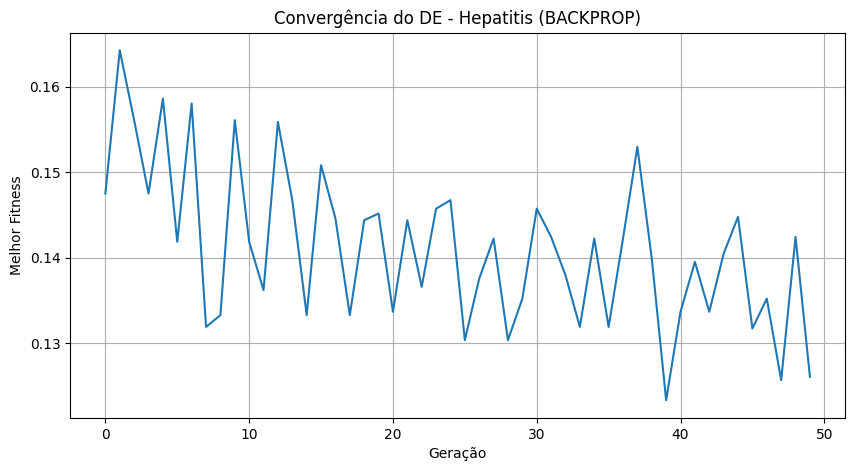


🏆 ANÁLISE DO CAMPEÃO PARA: Hepatitis com BACKPROP
  - Algoritmo Vencedor: DE (Fitness: 0.1233)

  --- Configuração Ótima de Hiperparâmetros ---
  - Número de Camadas Intermediárias: 1 (simplificado)
  - Número de Neurônios: (17,)
  - Taxa de Aprendizado: 0.0186
  - Número de Features Selecionadas: 3 de 19

  --- Relatório Final de Eficácia no Conjunto de Teste ---
              precision    recall  f1-score   support

           1       0.50      0.22      0.31         9
           2       0.84      0.95      0.89        38

    accuracy                           0.81        47
   macro avg       0.67      0.58      0.60        47
weighted avg       0.77      0.81      0.78        47

---------------------------------------------------

--- Iniciando experimento para Hepatitis com classificador ELM ---
Executando GA com ELM...


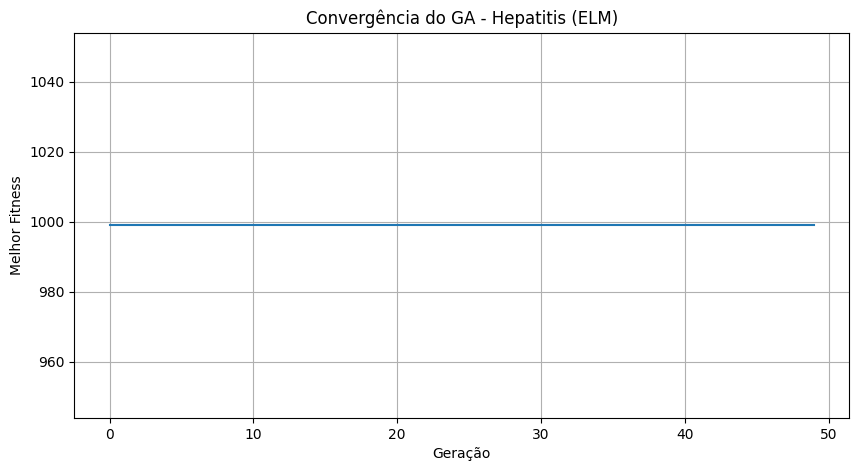

Executando DE com ELM...


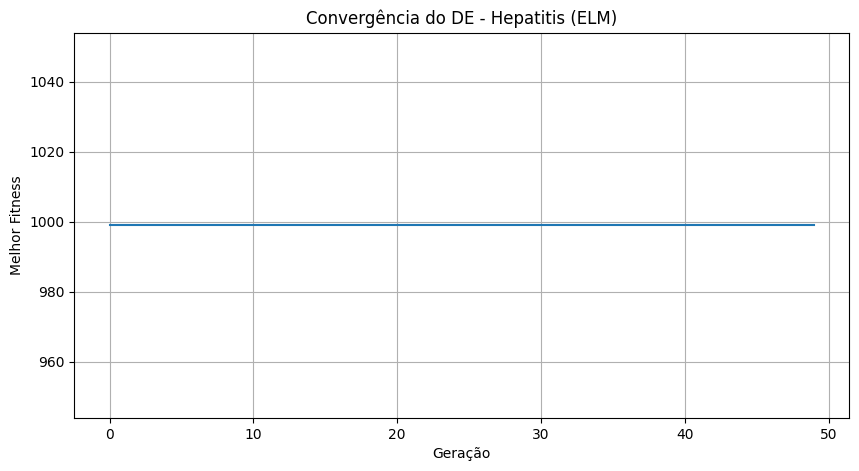


🏆 ANÁLISE DO CAMPEÃO PARA: Hepatitis com ELM
  - Algoritmo Vencedor: GA (Fitness: 999.0000)

  --- Configuração Ótima de Hiperparâmetros ---
  - Número de Camadas Intermediárias: 1 (simplificado)
  - Número de Neurônios: (22,)
  - Taxa de Aprendizado: 0.0771
  - Número de Features Selecionadas: 12 de 19
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons

  --- Relatório Final de Eficácia no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.18      0.89      0.30         9
           2       0.00      0.00      0.00        38

    accuracy                           0.17        47
   macro avg       0.06      0.30      0.10        47
weighted avg       0.03      0.17      0.06        47

---------------------------------------------------


>>> TODOS OS EXPERIMENTOS FORAM CONCLUÍDOS <<<


c:\Users\field\AppData\Local\Programs\Python\Python313\Lib\site-packages\hpelm\nnets\slfn.py:62: RuntimeWarning: overflow encountered in exp
  self.func["sigm"] = lambda X, W, B: 1 / (1 + np.exp(np.dot(X, W) + B))


In [ ]:
# EXECUÇÃO DO DATASET WINE E HEPATITIS ---

print(">>> INICIANDO TODOS OS EXPERIMENTOS DA TAREFA <<<")

# PREPARAÇÃO DOS DATASETS ---

# Carregar dataset WINE 
wine_data = load_wine()
X_wine, y_wine = wine_data.data, wine_data.target
print("\n[INFO] Dataset Wine carregado.")

# Carregar e preparar dataset HEPATITIS
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data'
column_names = [
    'Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 
    'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS', 
    'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 
    'PROTIME', 'HISTOLOGY'
]
hepatitis_df = pd.read_csv(url, header=None, names=column_names, na_values='?')
imputer = SimpleImputer(strategy='most_frequent')
hepatitis_imputed_df = pd.DataFrame(imputer.fit_transform(hepatitis_df), columns=column_names)
X_hep = hepatitis_imputed_df.drop('Class', axis=1)
y_hep = hepatitis_imputed_df['Class'].astype(int)
X_hep_np = X_hep.to_numpy()
y_hep_np = y_hep.to_numpy()
print("[INFO] Dataset Hepatitis carregado e pré-processado.")

# EXECUÇÃO DOS EXPERIMENTOS ---

# dataset --- WINE ---
print("\n" + "="*50)
print(">>> EXECUTANDO PARA DATASET: WINE <<<")
print("="*50)
# Wine com Backpropagation
resultados_wine_backprop = executar_experimento(X_wine, y_wine, "Wine", classifier_type='backprop')
# Wine com ELM
resultados_wine_elm = executar_experimento(X_wine, y_wine, "Wine", classifier_type='elm')

# dataset --- HEPATITIS ---
print("\n" + "="*50)
print(">>> EXECUTANDO PARA DATASET: HEPATITIS <<<")
print("="*50)
# Hepatitis com Backpropagation
resultados_hepatitis_backprop = executar_experimento(X_hep_np, y_hep_np, "Hepatitis", classifier_type='backprop')
# Hepatitis com ELM
resultados_hepatitis_elm = executar_experimento(X_hep_np, y_hep_np, "Hepatitis", classifier_type='elm')

print("\n>>> TODOS OS EXPERIMENTOS FORAM CONCLUÍDOS <<<")


### FITNES PARA REGRESSÃO
uso do dataset Diabetes

dataset diabetes é um problema de regressão (prever um valor numérico contínuo que mede a progressão da doença).

In [ ]:
#FUNÇÃO DE FITNESS PARA REGRESSÃO 

def calcular_fitness_regressao(individuo, X_data, y_data):
    #Calcula o fitness para um problema de REGRESSÃO.
    #O objetivo é minimizar o Erro Quadrático Médio (MSE).
    
    try:
        feature_mask = individuo["feature_mask"]
        num_selected_features = np.sum(feature_mask)
        
        if num_selected_features == 0:
            return 999999

        X_subset = X_data[:, feature_mask == 1]
        
        regressor = MLPRegressor(
            hidden_layer_sizes=individuo["hidden_layer_sizes"],
            learning_rate_init=individuo["learning_rate"],
            max_iter=500,
            random_state=42
        )
        
        # Validação cruzada com 3 folds em vez de 5
        mse_scores = cross_val_score(regressor, X_subset, y_data, cv=3, scoring='neg_mean_squared_error')
        
        mean_error = -np.mean(mse_scores)
        
        rho = 0.9
        feature_reduction_cost = num_selected_features / X_data.shape[1]
        fitness = rho * mean_error + (1 - rho) * feature_reduction_cost
        
        return fitness
    except Exception:
        return 999999

print("Função 'calcular_fitness_regressao' ATUALIZADA com cv=3.")

Função 'calcular_fitness_regressao' ATUALIZADA com cv=3.


#FUNÇÃO DE REGRESSÃO

In [ ]:
#FUNÇÃO PRINCIPAL DE REGRESSÃO ---

def executar_experimento_regressao(X, y, dataset_name):
   
    print(f"--- Iniciando experimento RÁPIDO para o dataset: {dataset_name} ---")
    
    
    num_features = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    def fitness_wrapper(p):
        feature_mask = (p[0:num_features] > 0.5).astype(int)
        num_neurons = int(p[num_features])
        learning_rate = p[num_features + 1]
        individuo = {"feature_mask": feature_mask, "hidden_layer_sizes": (num_neurons,), "learning_rate": learning_rate}
        return calcular_fitness_regressao(individuo, X_train, y_train)

    lb = [0] * num_features + [5, 0.001]
    ub = [1] * num_features + [100, 0.1]
    n_dim = num_features + 2

    # AJUSTES DE VELOCIDADE DO TREINAMENTO ---
    # O tamanho da população (size_pop) deve ser um número PAR.
    populacao = 30  # Alterado de 25 para 30
    geracoes = 40
    
    print(f"Executando GA para Regressão ({populacao} indivíduos, {geracoes} gerações)...")
    ga = GA(func=fitness_wrapper, n_dim=n_dim, size_pop=populacao, max_iter=geracoes, prob_mut=0.01, lb=lb, ub=ub)
    best_x_ga, best_y_ga = ga.run()
    plt.figure(figsize=(10, 5))
    plt.plot(ga.generation_best_Y)
    plt.title(f'Convergência do GA - {dataset_name} (Regressão Rápida)')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness (Erro)')
    plt.grid(True)
    plt.show()

    print(f"Executando DE para Regressão ({populacao} indivíduos, {geracoes} gerações)...")
    de = DE(func=fitness_wrapper, n_dim=n_dim, size_pop=populacao, max_iter=geracoes, lb=lb, ub=ub)
    best_x_de, best_y_de = de.run()
    plt.figure(figsize=(10, 5))
    plt.plot(de.generation_best_Y)
    plt.title(f'Convergência do DE - {dataset_name} (Regressão Rápida)')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness (Erro)')
    plt.grid(True)
    plt.show()

    # função para análise e relatório ...
    resultados_fitness = {"GA": best_y_ga[0], "DE": best_y_de[0]}
    campeao_nome = min(resultados_fitness, key=resultados_fitness.get)
    campeao_vetor = best_x_ga if campeao_nome == "GA" else best_x_de
    
    best_mask_final = (campeao_vetor[0:num_features] > 0.5).astype(int)
    best_num_neurons_final = int(campeao_vetor[num_features])
    best_lr_final = campeao_vetor[num_features + 1]

    print("\n" + "="*50)
    print(f"🏆 ANÁLISE DO CAMPEÃO PARA REGRESSÃO: {dataset_name}")
    print("="*50)
    print(f"  - Algoritmo Vencedor: {campeao_nome} (Fitness: {resultados_fitness[campeao_nome]:.4f})")
    print("\n  --- Configuração Ótima de Hiperparâmetros ---")
    print(f"  - Número de Neurônios: ({best_num_neurons_final},)")
    print(f"  - Taxa de Aprendizado: {best_lr_final:.4f}")
    print(f"  - Número de Features Selecionadas: {np.sum(best_mask_final)} de {num_features}")
    
    X_train_final = X_train[:, best_mask_final == 1]
    X_test_final = X_test[:, best_mask_final == 1]

    if X_train_final.shape[1] > 0:
        final_model = MLPRegressor(hidden_layer_sizes=(best_num_neurons_final,), learning_rate_init=best_lr_final, max_iter=2000, random_state=42)
        final_model.fit(X_train_final, y_train)
        y_pred_final = final_model.predict(X_test_final)

        mse = mean_squared_error(y_test, y_pred_final)
        r2 = r2_score(y_test, y_pred_final)

        print("\n  --- Relatório Final de Eficácia no Conjunto de Teste ---")
        print(f"  - Erro Quadrático Médio (MSE): {mse:.4f}")
        print(f"  - Coeficiente de Determinação (R²): {r2:.4f}")
    else:
        print("\nNenhuma feature selecionada, o modelo não foi treinado.")
    
    print("---------------------------------------------------\n")

print("Função para REGRESSÃO com população PAR.")

Função para REGRESSÃO ATUALIZADA com população PAR.


Dataset Diabetes carregado. Formato de X: (442, 10)
--- Iniciando experimento RÁPIDO para o dataset: Diabetes ---
Executando GA para Regressão (30 indivíduos, 40 gerações)...


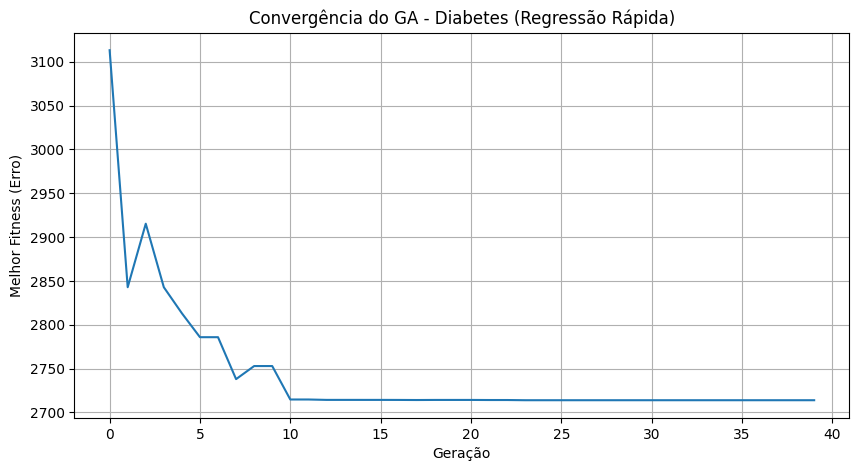

Executando DE para Regressão (30 indivíduos, 40 gerações)...


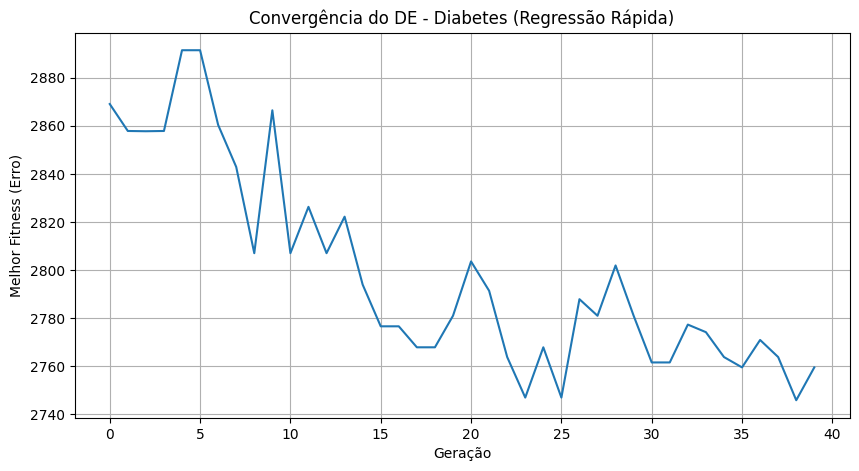


🏆 ANÁLISE DO CAMPEÃO PARA REGRESSÃO: Diabetes
  - Algoritmo Vencedor: GA (Fitness: 2713.8862)

  --- Configuração Ótima de Hiperparâmetros ---
  - Número de Neurônios: (88,)
  - Taxa de Aprendizado: 0.0525
  - Número de Features Selecionadas: 7 de 10

  --- Relatório Final de Eficácia no Conjunto de Teste ---
  - Erro Quadrático Médio (MSE): 2811.0640
  - Coeficiente de Determinação (R²): 0.4793
---------------------------------------------------



In [ ]:
# EXECUÇÃO PARA O DATASET DIABETES ---

from sklearn.datasets import load_diabetes

# Carregar os dados
diabetes_data = load_diabetes()
X_diabetes = diabetes_data.data
y_diabetes = diabetes_data.target

print(f"Dataset Diabetes carregado. Formato de X: {X_diabetes.shape}")

# Executar o experimento de regressão
resultados_diabetes = executar_experimento_regressao(X_diabetes, y_diabetes, "Diabetes")